# Lasso Regression

- The **theory** behind Lasso (and its differences with Ridge and Elastic Net).
- **Data preparation**: using both a real dataset (Diabetes) and a synthetic dataset to highlight feature selection.
- **Model implementation**: training Lasso with hyperparameter tuning and visualizing coefficient paths.
- **Comparisons** with Ridge, Linear Regression, and Elastic Net.
- **Discussion** on when to use Lasso and its strengths and limitations.

## 1. Introduction

Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression method that uses L1 regularization. The L1 penalty has the effect of shrinking some coefficients to exactly zero, which results in a sparse model. This property is particularly useful for:

- **Feature selection:** Automatically discarding irrelevant features.
- **Interpretability:** Simplifying models for easier interpretation.
- **High-dimensional data:** Situations where the number of features is large compared to the number of samples.

In this notebook, we not only demonstrate Lasso on the Diabetes dataset but also simulate a high-dimensional scenario to see how Lasso performs when many predictors are present.

## 2. Theoretical Background

### 2.1 Lasso Regression

Lasso solves the following optimization problem:

$$\min_{\beta_0, \beta} \left( \frac{1}{2N} \sum_{i=1}^{N} (y_i - \beta_0 - X_i \beta)^2 + \alpha \sum_{j=1}^{p} |\beta_j| \right)$$


Here, the term $\alpha \sum_{j=1}^{p} |\beta_j|$ is the L1 penalty. As $\alpha$ increases, more coefficients are shrunk to zero, promoting sparsity in the model.

### 2.2 Comparison with Other Methods

- **Ridge Regression** adds an L2 penalty: $\alpha \sum_{j=1}^{p} \beta_j^2$. This penalty shrinks coefficients but does not force them to be exactly zero.

- **Elastic Net** combines both L1 and L2 penalties:

 $$
  \alpha \left( \rho \sum_{j=1}^{p} |\beta_j| + (1-\rho) \sum_{j=1}^{p} \beta_j^2 \right)
 $$

  where $\rho$ (l1_ratio) controls the mix between L1 and L2 regularization.

The choice among these methods depends on the dataset characteristics and the goals (e.g., interpretability vs. prediction accuracy).

## 3. Data Preparation and Preprocessing

We will work with two datasets:

1. **Diabetes Dataset**: A real-world dataset from scikit-learn with 10 features and 442 samples.
2. **Synthetic Dataset**: A simulated dataset designed to demonstrate Lasso's feature selection capabilities in a high-dimensional setting.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

%matplotlib inline

sns.set(style="whitegrid", context="notebook")

### 3.1 Loading the Diabetes Dataset

We load the Diabetes dataset from scikit-learn. This dataset is useful for demonstrating Lasso's ability to shrink coefficients and perform feature selection.

In [11]:
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print(f"Diabetes Dataset shape: {X_diabetes.shape}")
print("Feature names:", diabetes.feature_names)


df_diabetes = pd.DataFrame(X_diabetes, columns=diabetes.feature_names)
df_diabetes['target'] = y_diabetes

display(df_diabetes.head())

Diabetes Dataset shape: (442, 10)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### 3.2 Creating a Synthetic Dataset

We generate a synthetic dataset where only a few features are truly informative. This example will allow us to observe Lasso's inherent feature selection capability.

In [16]:
n_samples, n_features = 100, 50
X_synthetic = np.random.randn(n_samples, n_features)

# Coefficients with sparsity
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[5:]] = 0  # Introduce sparsity (only first 5 features are non-zero)

# Adding noise
y_synthetic = np.dot(X_synthetic, coef) + np.random.normal(0, 0.5, n_samples)

# Convert to DataFrame
feature_names = [f'feature_{i}' for i in range(n_features)]
df_synthetic = pd.DataFrame(X_synthetic, columns=feature_names)

# Add target variable
df_synthetic['target'] = y_synthetic

display(df_synthetic.head())

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,-1.014661,-0.207629,-1.064533,0.635131,-1.943805,0.090425,0.519510,-0.090541,1.093223,-1.370561,...,-0.087402,1.062627,0.922428,0.184833,1.190539,-0.943486,1.077337,-0.790429,1.239695,-2.798039
1,-0.013346,-1.998287,0.730157,0.809546,-0.456580,-0.371260,-0.159545,-1.925152,-2.364728,1.301626,...,-0.879696,0.332807,0.081447,1.392865,2.473759,-1.262850,0.147305,0.145526,-0.014198,-8.016227
2,-1.084825,-0.917197,0.240406,-0.945350,0.159272,-0.245950,0.141658,-0.953300,0.157469,-0.880953,...,0.176799,-1.531460,0.375202,0.344478,1.222544,-0.309689,0.011996,-0.642808,0.597949,-8.404238
3,-0.783490,-0.892991,-0.067798,-1.225864,1.602131,1.927267,-0.453590,-1.386595,0.336592,-0.482103,...,-0.361597,1.553131,1.772812,-0.575493,0.577787,-0.552274,-0.286873,-0.605775,-1.724344,3.715548
4,0.095055,0.288165,-0.671002,1.087792,-0.436080,-0.637212,0.526503,-1.542682,0.906679,-0.402169,...,-0.331773,2.205783,0.566445,0.024923,0.819901,-0.480680,0.923015,0.895235,1.253534,-3.892180


## 4. Data Splitting and Scaling

Before fitting our models, we split each dataset into training and testing sets and standardize the features. Scaling is important for regularization methods such as Lasso.

In [17]:
def split_and_scale(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

X_train_d, X_test_d, y_train_d, y_test_d = split_and_scale(X_diabetes, y_diabetes)

X_train_s, X_test_s, y_train_s, y_test_s = split_and_scale(X_synthetic, y_synthetic)

## 5. Lasso Regression Implementation

### 5.1 Hyperparameter Tuning with Cross-Validation

We perform a grid search to select the optimal regularization parameter $\alpha$ for the Lasso model using 5-fold cross-validation.

In [18]:
# Range of alpha values
alpha_range = np.logspace(-4, 0.5, 50)

# Grid Search: Diabetes dataset
lasso_cv_d = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alpha_range}, cv=5)
lasso_cv_d.fit(X_train_d, y_train_d)

best_alpha_d = lasso_cv_d.best_params_['alpha']
print(f"Best alpha for Diabetes dataset: {best_alpha_d}")

# Fit the Lasso model: Diabetes dataset
lasso_d = Lasso(alpha=best_alpha_d, max_iter=10000)
lasso_d.fit(X_train_d, y_train_d)

# Test performance
y_pred_d = lasso_d.predict(X_test_d)
mse_d = mean_squared_error(y_test_d, y_pred_d)
r2_d = r2_score(y_test_d, y_pred_d)

print(f"Diabetes Dataset - Lasso MSE: {mse_d:.2f}")
print(f"Diabetes Dataset - Lasso R-squared: {r2_d:.2f}")

Best alpha for Diabetes dataset: 1.67683293681101
Diabetes Dataset - Lasso MSE: 2800.34
Diabetes Dataset - Lasso R-squared: 0.47


### 5.2 Lasso on Synthetic Data

We repeat the process for the synthetic dataset. Notice how the Lasso model selects only a few features (by setting many coefficients to zero).

In [19]:
# Grid Search: Synthetic dataset
lasso_cv_s = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alpha_range}, cv=5)
lasso_cv_s.fit(X_train_s, y_train_s)

best_alpha_s = lasso_cv_s.best_params_['alpha']
print(f"Best alpha for Synthetic dataset: {best_alpha_s}")

# Fitting the Lasso model: Synthetic dataset
lasso_s = Lasso(alpha=best_alpha_s, max_iter=10000)
lasso_s.fit(X_train_s, y_train_s)

# Test set performance
y_pred_s = lasso_s.predict(X_test_s)
mse_s = mean_squared_error(y_test_s, y_pred_s)
r2_s = r2_score(y_test_s, y_pred_s)

print(f"Synthetic Dataset - Lasso MSE: {mse_s:.2f}")
print(f"Synthetic Dataset - Lasso R-squared: {r2_s:.2f}")

selected_features = np.sum(lasso_s.coef_ != 0)
print(f"Number of selected features: {selected_features}")

Best alpha for Synthetic dataset: 0.05689866029018299
Synthetic Dataset - Lasso MSE: 0.28
Synthetic Dataset - Lasso R-squared: 0.99
Number of selected features: 21


## 6. Coefficient Path Analysis

Visualizing how the coefficients evolve as the regularization parameter changes can help us understand the effect of L1 regularization. We use the LARS algorithm (implemented in scikit-learn) to compute and plot the coefficient paths for the Diabetes dataset.

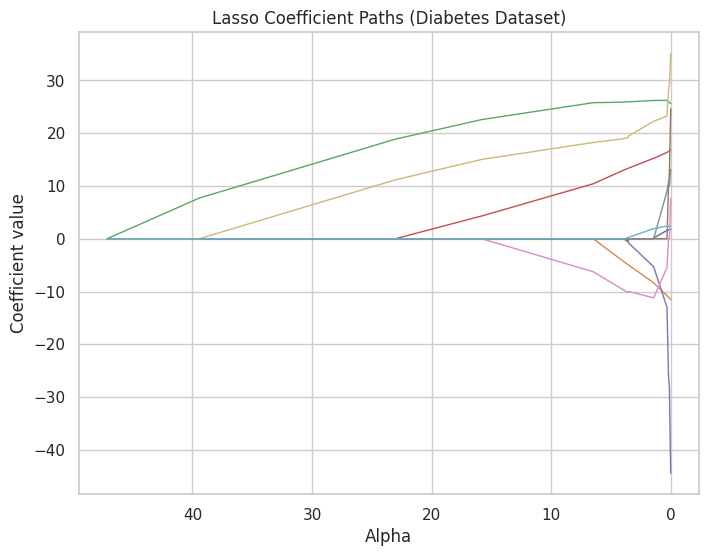

In [20]:
from sklearn.linear_model import lars_path

# Compute the Lasso path for the Diabetes dataset
alphas, _, coefs = lars_path(X_train_d, y_train_d, method='lasso')

plt.figure(figsize=(8, 6))
for coef in coefs:
    plt.plot(alphas, coef, lw=1)

plt.xlabel('Alpha')
plt.ylabel('Coefficient value')
plt.title('Lasso Coefficient Paths (Diabetes Dataset)')
plt.gca().invert_xaxis()  # Typically, we show decreasing alpha
plt.show()

## 7. Model Comparison

We now compare Lasso with Ridge Regression, Linear Regression, and Elastic Net on the Diabetes dataset. This helps in understanding the trade-offs between these methods.

In [23]:
# Models for the Diabetes dataset
ridge_d = Ridge(alpha=best_alpha_d)
linear_d = LinearRegression()
elastic_net_d = ElasticNet(alpha=best_alpha_d, l1_ratio=0.5, max_iter=10000)  # l1_ratio controls the mix of L1 and L2

# Fitting the models
ridge_d.fit(X_train_d, y_train_d)
linear_d.fit(X_train_d, y_train_d)
elastic_net_d.fit(X_train_d, y_train_d)

# Predictions
y_pred_ridge_d = ridge_d.predict(X_test_d)
y_pred_linear_d = linear_d.predict(X_test_d)
y_pred_en_d = elastic_net_d.predict(X_test_d)

# Evaluation metrics
mse_ridge_d = mean_squared_error(y_test_d, y_pred_ridge_d)
r2_ridge_d = r2_score(y_test_d, y_pred_ridge_d)

mse_linear_d = mean_squared_error(y_test_d, y_pred_linear_d)
r2_linear_d = r2_score(y_test_d, y_pred_linear_d)

mse_en_d = mean_squared_error(y_test_d, y_pred_en_d)
r2_en_d = r2_score(y_test_d, y_pred_en_d)

comparison_df_d = pd.DataFrame({
    "Model": ["Lasso", "Ridge", "Linear Regression", "Elastic Net"],
    "MSE": [mse_d, mse_ridge_d, mse_linear_d, mse_en_d],
    "R-squared": [r2_d, r2_ridge_d, r2_linear_d, r2_en_d]
})

display(comparison_df_d)

,Model,MSE,R-squared
0,Lasso,2800.340308,0.471450
1,Ridge,2888.878699,0.454738
2,Linear Regression,2900.193628,0.452603
3,Elastic Net,2978.450686,0.437832


## 8. When to Use Lasso?

### Advantages of Lasso

- **Feature Selection:** Lasso automatically sets some coefficients to zero, thereby performing variable selection.
- **Interpretability:** Sparse models are easier to interpret since only a subset of features remains.
- **High-Dimensional Data:** Particularly effective when the number of predictors is high compared to the number of observations.

### Limitations of Lasso

- **Multicollinearity:** In the presence of highly correlated features, Lasso might arbitrarily choose one feature over another.
- **Bias:** The shrinkage introduces bias in the coefficient estimates.
- **Dense Models:** If most predictors are relevant, methods like Ridge or Elastic Net might perform better.

### So When?

Use Lasso when you believe that only a subset of features is important, especially when interpretability and feature selection are key priorities. However, if your data has high multicollinearity or if you expect many features to contribute, consider using Ridge or Elastic Net instead.